## Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import LSTM, Bidirectional, Input, Dense, Dropout, Conv1D, Flatten, MaxPooling1D
from tensorflow.keras import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import re
from cleantext import clean
import nltk
from nltk.stem import WordNetLemmatizer


## Import Data

In [3]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
data.drop(columns = ["textID", "selected_text"], inplace = True)

## Text preprocessing

In [5]:
enc = LabelEncoder()
data["sentiment"] = enc.fit_transform(data["sentiment"])

In [6]:
data.dropna(subset = "text", inplace = True)

In [7]:
def clean_text(text):
    text = re.sub(r"@[\S]+", "", text)
    return clean(
        text,
        to_ascii = True,
        fix_unicode = True,
        no_urls = True,
        replace_with_url = "",
        no_currency_symbols=True,
        replace_with_currency_symbol="",
        no_punct = True,
        no_digits = True,
        replace_with_digit="",
    )

In [8]:
data["text"] = data["text"].apply(clean_text)

In [9]:
stop_words = [
    'a', 'an', 'and', 'are', 'as', 'at', 'be', 'by', "i", 'for', 'from', 'has',
    'have', 'he', 'her', 'him', 'his', 'in', 'is', 'it', 'its', 'of', 'on',
    'or', 'that', 'the', 'to', 'was', 'were', 'with', 'should', 'have', 'has', 'would', 'should', 'could', 'would', 'might',
    'must', 'shall', 'ought', 'need', 'dare', 'because', 'while', 'when', 'where', 'after',
    'before', 'although', 'though', 'if', 'unless', 'until', 'while', 'even', 'once', 'since',
    'so', 'than', 'that', 'though', 'till', 'when', 'whenever', 'whereas', 'wherever', 'whether',
    'which', 'while', 'who', 'whoever', 'whom', 'whose', 'how', 'why', 'what', 'where', 'when',
    'which', 'who', 'whom', 'this', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
    'been', 'being', 'have', 'has', 'had', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
    'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from',
    'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', "im", "wa", "ive"
]

In [10]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
lemmatizer = WordNetLemmatizer()
def remove_stopwords_stem(text):
    text = [lemmatizer.lemmatize(t) for t in text.split() if lemmatizer.lemmatize(t) not in stop_words]
    return " ".join(text)

In [12]:
data["text"] = data["text"].apply(remove_stopwords_stem)

In [13]:
data["text"] = data["text"].str.strip()
data = data[~data["text"].apply(lambda x:not(x))]

## View Labels

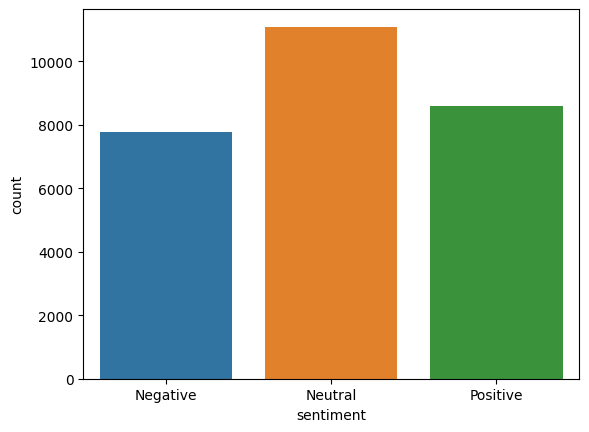

In [14]:
sns.countplot(x = data["sentiment"], )
plt.xticks((0, 1, 2),["Negative", "Neutral", "Positive"]);

## Word Clouds

In [15]:
import wordcloud

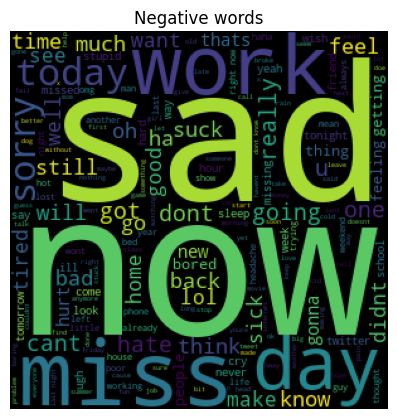

In [16]:
neg = data.loc[data["sentiment"] == 0, :]["text"]
neg_words = " ".join(neg.values)
neg_img = wordcloud.WordCloud(width = 300, height = 300).generate(neg_words)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(neg_img)
plt.axis("off")
plt.title("Negative words")
plt.tight_layout(pad = 0)


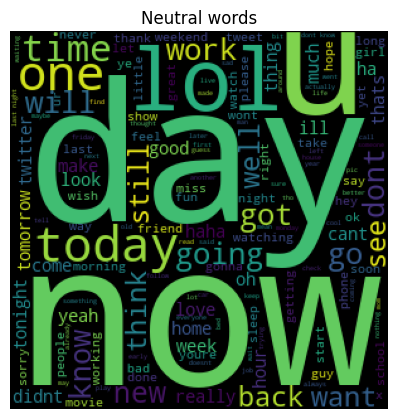

In [17]:
neu = data.loc[data["sentiment"] == 1, :]["text"]
neu_words = " ".join(neu.values)
neu_img = wordcloud.WordCloud(width = 300, height = 300).generate(neu_words)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(neu_img)
plt.axis("off")
plt.title("Neutral words")
plt.tight_layout(pad = 0)


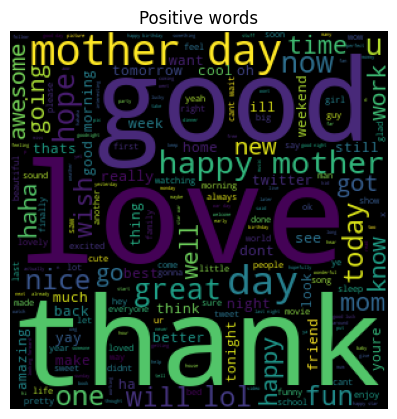

In [18]:
pos = data.loc[data["sentiment"] == 2, :]["text"]
pos_words = " ".join(pos.values)
pos_img = wordcloud.WordCloud(width = 300, height = 300).generate(pos_words)

plt.figure(figsize = (4, 4), facecolor = None)
plt.imshow(pos_img)
plt.axis("off")
plt.title("Positive words")
plt.tight_layout(pad = 0)


## Train Test split

In [19]:
X = data["text"]
y = data["sentiment"]

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [22]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_data_prefetched = train_data.batch(32).prefetch(tf.data.AUTOTUNE)
test_data_prefetched = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## Model1: Naive Bayes

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

In [24]:
tfidf = TfidfVectorizer(max_features = 5000, min_df = 3)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf = tfidf.transform(X_test)

In [25]:
mnb = MultinomialNB()
mnb.fit(X_train_tf, y_train)
y_pred = mnb.predict(X_test_tf)

In [26]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"Recall: {recall_score(y_test, y_pred, average = 'macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred, average = 'macro'):.2f}")

Accuracy: 0.63
Recall: 0.61
Precision: 0.69
F1 score: 0.63


## Model2: RandomForest

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
rdf = RandomForestClassifier()
rdf.fit(X_train_tf, y_train)
y_pred1 = rdf.predict(X_test_tf)

In [29]:
print(f"Accuracy: {accuracy_score(y_test, y_pred1):.2f}")
print(f"Recall: {recall_score(y_test, y_pred1, average = 'macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred1, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred1, average = 'macro'):.2f}")

Accuracy: 0.68
Recall: 0.68
Precision: 0.70
F1 score: 0.68


## Model3: SVM

In [30]:
from sklearn.svm import SVC

In [31]:
svc = SVC()
svc.fit(X_train_tf, y_train)
y_pred2 = svc.predict(X_test_tf)

In [32]:
print(f"Accuracy: {accuracy_score(y_test, y_pred2):.2f}")
print(f"Recall: {recall_score(y_test, y_pred2, average = 'macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred2, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred2, average = 'macro'):.2f}")

Accuracy: 0.68
Recall: 0.67
Precision: 0.72
F1 score: 0.68


#### Function to visualize model performance

In [33]:
def plot_model_performance(hist_obj, width = 10, height = 4):
    plt.figure(figsize = (width, height))
    plt.subplot(1, 2, 1)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["accuracy"], label = "train_acc")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_accuracy"], label = "val_acc")
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid(True)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["loss"], label = "train_loss")
    plt.plot(np.array(hist_obj.epoch)+1, hist_obj.history["val_loss"], label = "val_loss")
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

## Deep Learning Models (LSTM and Conv1D)

### Text Vectorization Layer

In [96]:
text_len = [len(i.split()) for i in X_train]

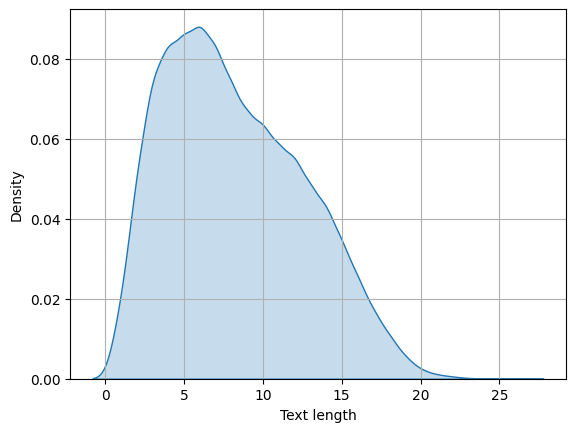

In [97]:
sns.kdeplot(text_len, fill = True)
plt.xlabel("Text length");
plt.grid(True)

In [98]:
text_vect = TextVectorization(
  max_tokens=5000,
  output_mode='int',
  output_sequence_length=15
)

text_vect.adapt(X_train)

### Embedding Layer

In [99]:
embed = Embedding(
    input_dim = 5000,
    output_dim = 256,
    input_length = 15
)

## Model4: LSTM

In [100]:
model_ckpt_lstm = ModelCheckpoint(
    filepath = "./saved_models/lstm_model/model4_lstm.pb",
    montior = "val_accuracy",
    save_best_only = True
)

In [101]:
model = Sequential()
model.add(Input(shape = (1,), dtype = tf.string))
model.add(text_vect)
model.add(embed)
model.add(LSTM(units = 32, dropout=0.5, return_sequences = True))
model.add(Bidirectional(LSTM(units = 32)))
model.add(Dense(units = 32, activation = "relu"))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 3, activation = "sigmoid"))

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
    metrics = ["accuracy"]
)

In [102]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_4 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_4 (Embedding)     (None, 15, 256)           1280000   
                                                                 
 lstm_10 (LSTM)              (None, 15, 32)            36992     
                                                                 
 bidirectional_5 (Bidirecti  (None, 64)                16640     
 onal)                                                           
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dropout_7 (Dropout)         (None, 32)               

In [103]:
lstm_hist = model.fit(train_data_prefetched, validation_data = test_data_prefetched, batch_size = 32, epochs = 5, callbacks=[model_ckpt_lstm])

Epoch 1/5


642/644 [============================>.] - ETA: 0s - loss: 0.8291 - accuracy: 0.6268INFO:tensorflow:Assets written to: ./saved_models/lstm_model\model4_lstm.pb\assets


INFO:tensorflow:Assets written to: ./saved_models/lstm_model\model4_lstm.pb\assets


644/644 [==============================] - 81s 111ms/step - loss: 0.8288 - accuracy: 0.6269 - val_loss: 0.6998 - val_accuracy: 0.7122
Epoch 2/5
643/644 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.7469INFO:tensorflow:Assets written to: ./saved_models/lstm_model\model4_lstm.pb\assets


INFO:tensorflow:Assets written to: ./saved_models/lstm_model\model4_lstm.pb\assets


644/644 [==============================] - 75s 116ms/step - loss: 0.6427 - accuracy: 0.7470 - val_loss: 0.6953 - val_accuracy: 0.7122
Epoch 3/5
644/644 [==============================] - 23s 36ms/step - loss: 0.5612 - accuracy: 0.7824 - val_loss: 0.7423 - val_accuracy: 0.7058
Epoch 4/5
644/644 [==============================] - 22s 34ms/step - loss: 0.4856 - accuracy: 0.8156 - val_loss: 0.8335 - val_accuracy: 0.6911
Epoch 5/5
644/644 [==============================] - 22s 34ms/step - loss: 0.4199 - accuracy: 0.8440 - val_loss: 0.9468 - val_accuracy: 0.6888


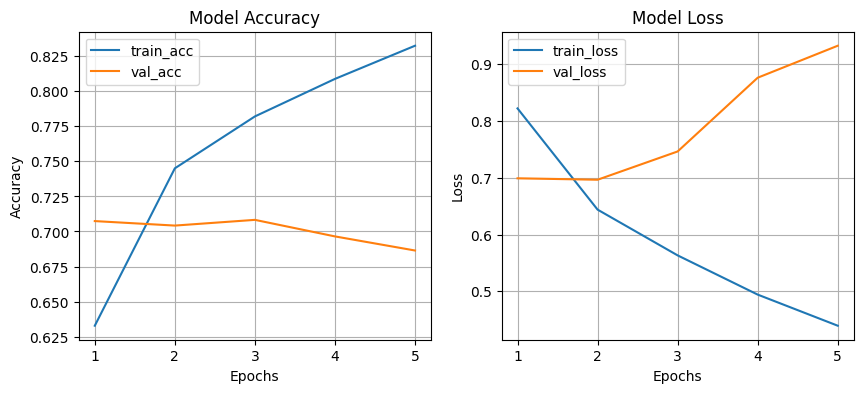

In [91]:
plot_model_performance(lstm_hist)

In [104]:
lstm_model = tf.keras.models.load_model("./saved_models/lstm_model/model4_lstm.pb")

In [105]:
lstm_model.evaluate(test_data_prefetched)

215/215 [==============================] - 5s 9ms/step - loss: 0.6953 - accuracy: 0.7122


[0.6952757835388184, 0.7122249603271484]

In [106]:
y_pred4_probs = lstm_model.predict(X_test)
y_pred4 = np.argmax(y_pred4_probs, axis = 1)

215/215 [==============================] - 5s 9ms/step


In [107]:
print(f"Accuracy: {accuracy_score(y_test, y_pred4):.2f}")
print(f"Recall: {recall_score(y_test, y_pred4, average = 'macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred4, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred4, average = 'macro'):.2f}")

Accuracy: 0.71
Recall: 0.70
Precision: 0.73
F1 score: 0.71


## Model5: Conv1D

In [47]:
model_ckpt_conv_lstm = ModelCheckpoint(
    filepath = "./saved_models/conv1d_model/model5_conv1d.pb",
    montior = "val_accuracy",
    save_best_only = True
)

In [48]:
model5 = Sequential()
model5.add(Input(shape = (1,), dtype = tf.string))
model5.add(text_vect)
model5.add(embed)
model5.add(Conv1D(filters=128, kernel_size = 5, strides=1))
model5.add(MaxPooling1D(pool_size = 3, strides=1, padding = 'same'))
model5.add(Conv1D(filters=64, kernel_size = 5, strides=1))
model5.add(MaxPooling1D(pool_size = 3, strides=1, padding = 'valid'))
model5.add(Flatten())
model5.add(Dropout(rate = 0.5))
model5.add(Dense(units = 128, activation = 'relu'))
model5.add(Dropout(rate = 0.5))
model5.add(Dense(units = 3, activation = 'softmax'))

In [49]:
model5.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"],
)

In [50]:
model5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 256)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 128)           163968    
                                                                 
 max_pooling1d (MaxPooling1  (None, 11, 128)           0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 64)             41024     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 64)            

In [51]:
convlstm_hist = model5.fit(train_data_prefetched, validation_data = test_data_prefetched, batch_size = 32, epochs = 5, callbacks=[model_ckpt_conv_lstm])

Epoch 1/5


644/644 [==============================] - ETA: 0s - loss: 0.5963 - accuracy: 0.7589INFO:tensorflow:Assets written to: ./saved_models/conv1d_model\model5_conv1d.pb\assets


INFO:tensorflow:Assets written to: ./saved_models/conv1d_model\model5_conv1d.pb\assets


644/644 [==============================] - 11s 15ms/step - loss: 0.5963 - accuracy: 0.7589 - val_loss: 0.8721 - val_accuracy: 0.6758
Epoch 2/5
644/644 [==============================] - 8s 12ms/step - loss: 0.4284 - accuracy: 0.8348 - val_loss: 1.1003 - val_accuracy: 0.6730
Epoch 3/5
644/644 [==============================] - 8s 13ms/step - loss: 0.3566 - accuracy: 0.8632 - val_loss: 1.2627 - val_accuracy: 0.6593
Epoch 4/5
644/644 [==============================] - 8s 13ms/step - loss: 0.3027 - accuracy: 0.8856 - val_loss: 1.4392 - val_accuracy: 0.6585
Epoch 5/5
644/644 [==============================] - 8s 12ms/step - loss: 0.2635 - accuracy: 0.9043 - val_loss: 1.7098 - val_accuracy: 0.6631


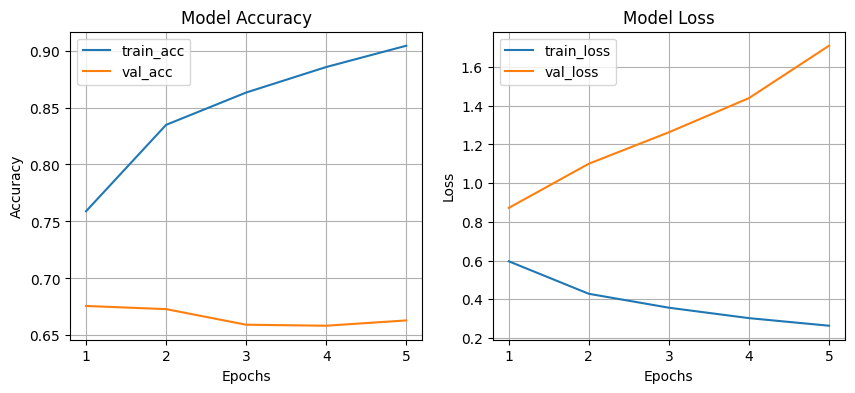

In [52]:
plot_model_performance(convlstm_hist)

In [53]:
conv1d_model = tf.keras.models.load_model("./saved_models/conv1d_model/model5_conv1d.pb")

In [54]:
conv1d_model.evaluate(test_data_prefetched)

215/215 [==============================] - 1s 3ms/step - loss: 0.8721 - accuracy: 0.6758


[0.8721065521240234, 0.6757977604866028]

In [55]:
y_pred5_probs = conv1d_model.predict(X_test)
y_pred5 = np.argmax(y_pred5_probs, axis = 1)

215/215 [==============================] - 1s 3ms/step


In [56]:
print(f"Accuracy: {accuracy_score(y_test, y_pred5):.2f}")
print(f"Recall: {recall_score(y_test, y_pred5, average = 'macro'):.2f}")
print(f"Precision: {precision_score(y_test, y_pred5, average = 'macro'):.2f}")
print(f"F1 score: {f1_score(y_test, y_pred5, average = 'macro'):.2f}")

Accuracy: 0.68
Recall: 0.67
Precision: 0.69
F1 score: 0.67


### Conclusion: Deep learning model with LSTM outperforms other models